# Madrid quality air forecast: Part I - Data exploration and data preprocess

This project has been inspired in the work of Robert Monarch: AI for good specialization. (https://www.coursera.org/specializations/ai-for-good). And also I took the liberty of using his nice plotting code. 

In this notebook we are going to explore air quality of Madrid. 

Data is periodically published in https://datos.madrid.es/ (Madrid city council).







## Import Python packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime # package for manipulating dates
from sklearn.impute import KNNImputer # package used to impute missing data 

import utils # utilities for this notebook

## Download data for each month and generate a single data file 

We are going to use two different types of data. 
1. Data from stations (station name, lattitude, longitude, etc.)
2. Monthly data files with the measures of pollutants

Data from stations can be donladed from here: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=9e42c176313eb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

Dataset with measures can be obtained from: https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default

Data with measures is split in a file per month and the format of the files is not ready to be used by a time series model.
In order to use the data in a consistent way, it is necessary to merge all monthly files in a single one (all-months-data.csv) and then we will have to transform the data in a time series format.

Project structure contains two folders:
1. "data": folder to store downloaded data.
2. "model": folder where the models will be allocated.

    

### Generating a single file with data from monthly files 

In [2]:

data_source_dir = './data/Anio23' # This is the subdirectory, to store all data files downloaded from the current year 
data_dir = './data' # folder where it will be generated the single file containing data of all months
all_months_filename = 'all-months-data.csv'

# This code merges all downloaded files into a songle one.
# It is commented to prevent the execution because it has to be run only once.
''' 
import shutil
import glob


#import csv files from folder
path = data_source_dir + "/" #r'./data/Anio23'
allFiles = glob.glob(path + "*.csv")
allFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters
with open(data_dir + "/" + all_months_filename, 'wb') as outfile:
    for i, fname in enumerate(allFiles):
        with open(fname, 'rb') as infile:
            if i != 0:
                infile.readline()  # Throw away header on all but first file
            # Block copy rest of file from input to output without parsing
            shutil.copyfileobj(infile, outfile)
            print(fname + " has been imported.")
'''            

' \nimport shutil\nimport glob\n\n\n#import csv files from folder\npath = data_source_dir + "/" #r\'./data/Anio23\'\nallFiles = glob.glob(path + "*.csv")\nallFiles.sort()  # glob lacks reliable ordering, so impose your own if output order matters\nwith open(data_dir + "/" + all_months_filename, \'wb\') as outfile:\n    for i, fname in enumerate(allFiles):\n        with open(fname, \'rb\') as infile:\n            if i != 0:\n                infile.readline()  # Throw away header on all but first file\n            # Block copy rest of file from input to output without parsing\n            shutil.copyfileobj(infile, outfile)\n            print(fname + " has been imported.")\n'

### Reading the stations (file was previously downloaded)

In [3]:
df_stations = pd.read_csv('./data/informacion_estaciones_red_calidad_aire.csv', sep=';')
df_stations = df_stations[['CODIGO_CORTO', 'ESTACION']]

# renaming columns
df_stations = df_stations.rename(columns={'CODIGO_CORTO': 'Station', 'ESTACION': 'Name'})


### Reading pollutant measures file

The format of the data in this file is not adequate to feed a model and it is necessary to transform the data structure.
Each row contains data per station, day and pollutant (magnitud). Measures of the pollutant are split in 24 columns (one column per hour) E.g. H01 (1:00am), H02 (2:00am)... H24 (24:00) and also there is an associated colum called V01, V02... V24 that represents if each measure has been validated for the specific hour.

In [4]:
raw_data = pd.read_csv(data_dir + "/" + all_months_filename, sep=';')
raw_data['row_id'] = raw_data['ANO'].astype(str) +'_' + raw_data['MES'].astype(str) +'_' + raw_data['DIA'].astype(str) +'_' + raw_data.reset_index().index.astype(str)

print(raw_data.shape)
raw_data.head()


(23488, 57)


,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANO,MES,DIA,H01,V01,...,V20,H21,V21,H22,V22,H23,V23,H24,V24,row_id
0,28,79,4,1,28079004_1_38,2023,4,1,1.0,V,...,V,1.0,V,1.0,V,1.0,V,1.0,V,2023_4_1_0
1,28,79,4,1,28079004_1_38,2023,4,2,1.0,V,...,V,1.0,V,1.0,V,1.0,V,1.0,V,2023_4_2_1
2,28,79,4,1,28079004_1_38,2023,4,3,1.0,V,...,V,1.0,V,1.0,V,1.0,V,1.0,V,2023_4_3_2
3,28,79,4,1,28079004_1_38,2023,4,4,1.0,V,...,V,1.0,V,1.0,V,1.0,V,1.0,V,2023_4_4_3
4,28,79,4,1,28079004_1_38,2023,4,5,1.0,V,...,V,1.0,V,1.0,V,1.0,V,1.0,V,2023_4_5_4


### Transforming data to a time series format.

We need to transpose the hours from columns to rows. Doing this, we will create 24 rows per day (one day = 24 hours).
Other than that, column namess will be translated to English be consistent.



In [5]:

magnitud_code = {
    1: 'SO2', # Dióxido de Azufre
    6: 'CO',  # Monóxido de Carbono
    7: 'NO', # Monóxido de Nitrógeno
    8: 'NO2', # Dióxido de Nitrógeno
    9: 'PM25', # Partículas < 2.5 μm
    10: 'PM10', # Partículas < 10 μm
    12: 'NOX', # Óxidos de Nitrógeno
    14: 'O3', # Ozono
    20: 'TOL', # Tolueno
    30: 'BEN', # Benceno
    35: 'EBE', # Etilbenceno
    37: 'MXY', # Metaxileno
    38: 'PXY', # Paraxileno
    39: 'OXY', # Ortoxileno
    42: 'TCH', # Hidrocarburos totales (hexano)
    43: 'CH4', # Metano  
}



temp_list = []

for row in raw_data.itertuples():
    for hour in np.arange(1, 25):
        
        #getting hour value
        hour_field_name = 'H'+ str(hour).zfill(2)
        value = row[raw_data.columns.get_loc(hour_field_name) + 1]
        
        #getting validated value and transforming V=1 N=0
        validated_field_name= 'V'+ str(hour).zfill(2)
        validated = 0
        if row[raw_data.columns.get_loc(validated_field_name) + 1] == 'V':
            validated = 1        
        
        #getting magnitud code from value
        magnitud = magnitud_code.get(row.MAGNITUD, 'UNKNOWN')
        
        temp_list.append(
            {
                'row_id': row.row_id,
                'Province': row.PROVINCIA,
                'City': row.MUNICIPIO,
                'Station':  row.ESTACION,
                'check_point': row.PUNTO_MUESTREO,
                'Year': row.ANO,
                'Month': row.MES,
                'Day': row.DIA,
                'Hour': hour,
                
                #'magnitud': magnitud,
                #'value': value,
                #'validated': validated,
                
                #setting magnitud value only in the corresponding field
                'SO2': value if magnitud == 'SO2' else None, 
                'CO': value if magnitud == 'CO' else None,  
                'NO': value if magnitud == 'NO' else None, 
                'NO2': value if magnitud == 'NO2' else None, 
                'PM25': value if magnitud == 'PM25' else None,
                'PM10': value if magnitud == 'PM10' else None,
                'NOX': value if magnitud == 'NOX' else None,
                'O3': value if magnitud == 'O3' else None, 
                'TOL': value if magnitud == 'TOL' else None,
                'BEN': value if magnitud == 'BEN' else None,
                'EBE': value if magnitud == 'EBE' else None,
                'MXY': value if magnitud == 'MXY' else None,
                'PXY': value if magnitud == 'PXY' else None,
                'OXY': value if magnitud == 'OXY' else None,
                'TCH': value if magnitud == 'TCH' else None,
                'CH4': value if magnitud == 'CH4' else None,                
                
                #setting validated value only in the corresponding field
                'VAL_SO2': validated if magnitud == 'SO2'  else None, 
                'VAL_CO':  validated if magnitud == 'CO'   else None,  
                'VAL_NO':  validated if magnitud == 'NO'   else None, 
                'VAL_NO2': validated if magnitud == 'NO2'  else None, 
                'VAL_PM25':validated if magnitud == 'PM25' else None,
                'VAL_PM10':validated if magnitud == 'PM10' else None,
                'VAL_NOX': validated if magnitud == 'NOX'  else None,
                'VAL_O3':  validated if magnitud == 'O3'   else None, 
                'VAL_TOL': validated if magnitud == 'TOL'  else None,
                'VAL_BEN': validated if magnitud == 'BEN'  else None,
                'VAL_EBE': validated if magnitud == 'EBE'  else None,
                'VAL_MXY': validated if magnitud == 'MXY'  else None,
                'VAL_PXY': validated if magnitud == 'PXY'  else None,
                'VAL_OXY': validated if magnitud == 'OXY'  else None,
                'VAL_TCH': validated if magnitud == 'TCH'  else None,
                'VAL_CH4': validated if magnitud == 'CH4'  else None,                
                
                
            }
    
        )

df = pd.DataFrame(temp_list)


In [6]:
fixed_columns = [#'row_id',
                'Province',
                'City',
                'Station',
                #'check_point',
                'Year',
                'Month',
                'Day',
                'Hour'
                ]
#this is not used
variable_columns=[
                'SO2',
                'CO',
                'NO',
                'NO2',
                'PM25',
                'PM10',
                'NOX',
                'O3',
                'TOL',
                'BEN',
                'EBE',
                'MXY',
                'PXY',
                'OXY',
                'TCH',
                'CH4',  
                                
    
                'VAL_SO2',
                'VAL_CO',
                'VAL_NO',
                'VAL_NO2',
                'VAL_PM25',
                'VAL_PM10',
                'VAL_NOX',
                'VAL_O3',
                'VAL_TOL',
                'VAL_BEN',
                'VAL_EBE',
                'VAL_MXY',
                'VAL_PXY',
                'VAL_OXY',
                'VAL_TCH',
                'VAL_CH4'        
                ]
aggregate_columns={                 
                 'SO2': 'sum', 'VAL_SO2': 'sum',
                  'CO': 'sum', 'VAL_CO': 'sum',
                  'NO': 'sum', 'VAL_NO': 'sum',
                 'NO2': 'sum', 'VAL_NO2': 'sum',
                'PM25': 'sum', 'VAL_PM25': 'sum',
                'PM10': 'sum', 'VAL_PM10': 'sum',
                 'NOX': 'sum', 'VAL_NOX': 'sum',
                  'O3': 'sum', 'VAL_O3': 'sum',
                 'TOL': 'sum', 'VAL_TOL': 'sum',
                 'BEN': 'sum', 'VAL_BEN': 'sum',
                 'EBE': 'sum', 'VAL_EBE': 'sum',
                 'MXY': 'sum', 'VAL_MXY': 'sum',
                 'PXY': 'sum', 'VAL_PXY': 'sum',
                 'OXY': 'sum', 'VAL_OXY': 'sum',
                 'TCH': 'sum', 'VAL_TCH': 'sum',
                 'CH4': 'sum', 'VAL_CH4': 'sum',  

                  }

df = df.groupby(fixed_columns, as_index=False).aggregate(aggregate_columns).sort_values(['Station','Year','Month','Day','Hour'], ascending=True)


df.head()


,Province,City,Station,Year,Month,Day,Hour,SO2,VAL_SO2,CO,...,MXY,VAL_MXY,PXY,VAL_PXY,OXY,VAL_OXY,TCH,VAL_TCH,CH4,VAL_CH4
0,28,79,4,2023,1,1,1,1.0,1.0,0.3,...,0,0,0,0,0,0,0,0,0,0
1,28,79,4,2023,1,1,2,3.0,1.0,0.4,...,0,0,0,0,0,0,0,0,0,0
2,28,79,4,2023,1,1,3,3.0,1.0,0.4,...,0,0,0,0,0,0,0,0,0,0
3,28,79,4,2023,1,1,4,2.0,1.0,0.4,...,0,0,0,0,0,0,0,0,0,0
4,28,79,4,2023,1,1,5,1.0,1.0,0.3,...,0,0,0,0,0,0,0,0,0,0


### Delete all measures that are not validated
Value not validated means that data could be wrong. In order to get clean data, we are going to remove all rows that contains values not validated. 

In [7]:
# Remove values when not validated
df['SO2']  = np.where(df['VAL_SO2'] == 0, np.nan, df['SO2'])
df['CO']  = np.where(df['VAL_CO'] == 0, np.nan, df['CO'])
df['NO']  = np.where(df['VAL_NO'] == 0, np.nan, df['NO'])
df['NO2']  = np.where(df['VAL_NO2'] == 0, np.nan, df['NO2'])
df['PM25']  = np.where(df['VAL_PM25'] == 0, np.nan, df['PM25'])
df['PM10']  = np.where(df['VAL_PM10'] == 0, np.nan, df['PM10'])
df['NOX']  = np.where(df['VAL_NOX'] == 0, np.nan, df['NOX'])
df['O3']  = np.where(df['VAL_O3'] == 0, np.nan, df['O3'])
df['TOL']  = np.where(df['VAL_TOL'] == 0, np.nan, df['TOL'])
df['BEN']  = np.where(df['VAL_BEN'] == 0, np.nan, df['BEN'])
df['EBE']  = np.where(df['VAL_EBE'] == 0, np.nan, df['EBE'])
df['MXY']  = np.where(df['VAL_MXY'] == 0, np.nan, df['MXY'])
df['PXY']  = np.where(df['VAL_PXY'] == 0, np.nan, df['PXY'])
df['OXY']  = np.where(df['VAL_OXY'] == 0, np.nan, df['OXY'])
df['TCH']  = np.where(df['VAL_TCH'] == 0, np.nan, df['TCH'])
df['CH4' ]  = np.where(df['VAL_CH4' ] == 0, np.nan, df['CH4' ])


columns_to_remove=[
                'VAL_SO2',
                'VAL_CO',
                'VAL_NO',
                'VAL_NO2',
                'VAL_PM25',
                'VAL_PM10',
                'VAL_NOX',
                'VAL_O3',
                'VAL_TOL',
                'VAL_BEN',
                'VAL_EBE',
                'VAL_MXY',
                'VAL_PXY',
                'VAL_OXY',
                'VAL_TCH',
                'VAL_CH4'        
                ]
df.drop(columns_to_remove, axis=1, inplace=True)

df.head()

,Province,City,Station,Year,Month,Day,Hour,SO2,CO,NO,...,NOX,O3,TOL,BEN,EBE,MXY,PXY,OXY,TCH,CH4
0,28,79,4,2023,1,1,1,1.0,0.3,28.0,...,76.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,28,79,4,2023,1,1,2,3.0,0.4,30.0,...,84.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,28,79,4,2023,1,1,3,3.0,0.4,49.0,...,112.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,28,79,4,2023,1,1,4,2.0,0.4,29.0,...,82.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,79,4,2023,1,1,5,1.0,0.3,17.0,...,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Checking missing values

At first sight, it seems that there are a lot of missing pollutants values, but after checking the data, we realized that the stations don't have values for all pollutants.
Next table is displaying the percentage of missing values.

In [8]:
NA = pd.DataFrame(data=[df.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (df.isna().sum()/df.shape[0]*100).tolist()]], 
           columns=df.columns, index=['NA Count', 'NA Percent']).transpose()

NA.style.background_gradient(cmap="Pastel1_r", subset=['NA Count'])


,NA Count,NA Percent
Province,0,0.00%
City,0,0.00%
Station,0,0.00%
Year,0,0.00%
Month,0,0.00%
Day,0,0.00%
Hour,0,0.00%
SO2,87346,84.91%
CO,86234,83.83%
NO,2246,2.18%


### Checking percentage of missing values per station
Next grid is representing the percentage of missing pollutants at station level

In [9]:
# Percentage of missing values per Station

magnitude_columns=[
                'SO2',
                'CO',
                'NO',
                'NO2',
                'PM25',
                'PM10',
                'NOX',
                'O3',
                'TOL',
                'BEN',
                'EBE'] 


df_stat = pd.DataFrame()
df_stat['SO2_Empty'] = df.SO2.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['SO2_Not_Empty'] = df.SO2.groupby([df['Station']]).count().astype(int)

df_stat['CO_Empty'] = df.CO.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['CO_Not_Empty'] = df.CO.groupby([df['Station']]).count().astype(int)

df_stat['NO_Empty'] = df.NO.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['NO_Not_Empty'] = df.NO.groupby([df['Station']]).count().astype(int)

df_stat['NO2_Empty'] = df.NO2.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['NO2_Not_Empty'] = df.NO2.groupby([df['Station']]).count().astype(int)

df_stat['PM25_Empty'] = df.PM25.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['PM25_Not_Empty'] = df.PM25.groupby([df['Station']]).count().astype(int)

df_stat['PM10_Empty'] = df.PM10.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['PM10_Not_Empty'] = df.PM10.groupby([df['Station']]).count().astype(int)

df_stat['NOX_Empty'] = df.NOX.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['NOX_Not_Empty'] = df.NOX.groupby([df['Station']]).count().astype(int)

df_stat['O3_Empty'] = df.O3.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['O3_Not_Empty'] = df.O3.groupby([df['Station']]).count().astype(int)

df_stat['TOL_Empty'] = df.TOL.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['TOL_Not_Empty'] = df.TOL.groupby([df['Station']]).count().astype(int)

df_stat['BEN_Empty'] = df.BEN.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['BEN_Not_Empty'] = df.BEN.groupby([df['Station']]).count().astype(int)

df_stat['EBE_Empty'] = df.EBE.isnull().groupby([df['Station']]).sum().astype(int)
df_stat['EBE_Not_Empty'] = df.EBE.groupby([df['Station']]).count().astype(int)


df_stat['SO2'] = (df_stat['SO2_Empty'] / (df_stat['SO2_Empty'] + df_stat['SO2_Not_Empty'])) *100
df_stat['CO'] = (df_stat['CO_Empty'] / (df_stat['CO_Empty'] + df_stat['CO_Not_Empty'])) *100
df_stat['NO'] = (df_stat['NO_Empty'] / (df_stat['NO_Empty'] + df_stat['NO_Not_Empty'])) *100
df_stat['NO2'] = (df_stat['NO2_Empty'] / (df_stat['NO2_Empty'] + df_stat['NO2_Not_Empty'])) *100
df_stat['PM25'] = (df_stat['PM25_Empty'] / (df_stat['PM25_Empty'] + df_stat['PM25_Not_Empty'])) *100
df_stat['PM10'] = (df_stat['PM10_Empty'] / (df_stat['PM10_Empty'] + df_stat['PM10_Not_Empty'])) *100
df_stat['NOX'] = (df_stat['NOX_Empty'] / (df_stat['NOX_Empty'] + df_stat['NOX_Not_Empty'])) *100
df_stat['O3'] = (df_stat['O3_Empty'] / (df_stat['O3_Empty'] + df_stat['O3_Not_Empty'])) *100
df_stat['TOL'] = (df_stat['TOL_Empty'] / (df_stat['TOL_Empty'] + df_stat['TOL_Not_Empty'])) *100
df_stat['BEN'] = (df_stat['BEN_Empty'] / (df_stat['BEN_Empty'] + df_stat['BEN_Not_Empty'])) *100
df_stat['EBE'] = (df_stat['EBE_Empty'] / (df_stat['EBE_Empty'] + df_stat['EBE_Not_Empty'])) *100




df_stat = df_stat[magnitude_columns]
df_stat[df_stat == 100] = '-' 

df_stat = pd.merge(df_stat, df_stations, on='Station', how='inner')
df_stat.style.format(precision=2).background_gradient(cmap="Pastel1_r")

,Station,SO2,CO,NO,NO2,PM25,PM10,NOX,O3,TOL,BEN,EBE,Name
0,4,1.91,1.40,1.31,1.31,-,-,1.31,-,-,-,-,Plaza de España
1,8,1.75,1.34,1.15,1.15,1.70,2.35,1.15,0.94,4.67,5.02,3.84,Escuelas Aguirre
2,11,-,-,1.93,1.93,-,-,1.93,-,17.47,4.90,3.63,Ramón y Cajal
3,16,-,-,0.83,0.83,-,-,0.83,0.85,-,-,-,Arturo Soria
4,17,-,-,1.31,1.31,-,-,1.31,1.61,-,-,-,Villaverde
5,18,-,-,1.61,1.61,-,6.91,1.61,1.77,10.01,8.84,9.97,Farolillo
6,24,-,-,9.21,9.21,2.37,2.30,9.21,1.52,1.66,1.43,1.38,Casa de Campo
7,27,-,-,1.22,1.22,-,-,1.22,1.93,-,-,-,Barajas Pueblo
8,35,17.86,13.42,8.59,8.59,-,-,8.59,1.08,-,-,-,Plaza del Carmen
9,36,21.25,-,1.01,1.01,-,1.20,1.01,-,-,-,-,Moratalaz


### Filtering pollutants used in this project
At the moment the only pollutants used for this project will be: NO, NO2, PM2.5, PM10, NOX

In [10]:

# removing columns with magnitude that will not included in predictions
incomplete_columns=[
                'SO2',
                'CO',
                #'NO',
                #'NO2',
                #'PM25',
                #'PM10',
                #'NOX',
                'O3',
                'TOL',
                'BEN',
                'EBE',
                'MXY',
                'PXY',
                'OXY',
                'TCH',
                'CH4'
                ]
df.drop(incomplete_columns, axis=1, inplace=True)

# adding datetime column
df['DateTime']=pd.to_datetime(df[['Year', 'Month', 'Day', 'Hour']])

# add some extra features like latitude and longitude to the data for mapping
df = utils.add_extra_features(df)
df.head()





,Province,City,Station,Year,Month,Day,Hour,NO,NO2,PM25,PM10,NOX,DateTime,Name,Latitude,Longitude,day_of_week,hour_of_day
0,28,79,4,2023,1,1,1,28.0,34.0,NaN,NaN,76.0,2023-01-01 01:00:00,Plaza de España,40.423883,-3.712197,6,1
1,28,79,4,2023,1,1,2,30.0,38.0,NaN,NaN,84.0,2023-01-01 02:00:00,Plaza de España,40.423883,-3.712197,6,2
2,28,79,4,2023,1,1,3,49.0,37.0,NaN,NaN,112.0,2023-01-01 03:00:00,Plaza de España,40.423883,-3.712197,6,3
3,28,79,4,2023,1,1,4,29.0,37.0,NaN,NaN,82.0,2023-01-01 04:00:00,Plaza de España,40.423883,-3.712197,6,4
4,28,79,4,2023,1,1,5,17.0,33.0,NaN,NaN,58.0,2023-01-01 05:00:00,Plaza de España,40.423883,-3.712197,6,5


## Plotting data 

### Histogram
It shows the distribution of the data.

In [11]:
# Define a number of bins to use (
number_of_bins=64

# Generate histograms
utils.create_histogram_plot(df, number_of_bins)

interactive(children=(Dropdown(description='Station', options=(4, 8, 11, 16, 17, 18, 24, 27, 35, 36, 38, 39, 4…

### Correlation Matrix
It represents the relationship between two variables and it displays how different variables correlate with each other

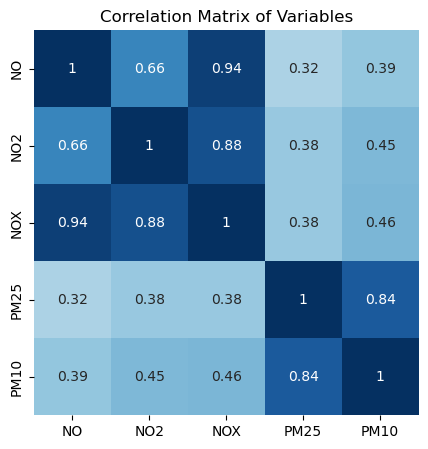

In [12]:
pollutants_list=[
                'NO',
                'NO2',
                'NOX',
                'PM25',
                'PM10'
                ]


# generate a correlation matrix
utils.create_correlation_matrix(df, pollutants_list)

### Time series
It represents the values of a pollutant along the time

In [13]:


# define the date range to show in the plot
start_date = datetime(2023, 2, 1)
end_date = datetime(2023, 2, 28)
# generate a time series plot of pollutant data for a paricular station
utils.create_time_series_plot(df, pollutants_list, start_date, end_date)

interactive(children=(Dropdown(description='Station', options=(4, 8, 11, 16, 17, 18, 24, 27, 35, 36, 38, 39, 4…

## Map representation

This map based on the PM2.5 measurements across the city of Madrid. Every circle in the map represents a station. Clicking on a circle, it will be displayed a plot of the hourly average and the recommended level of PM2.5.


In [15]:

# choose a variable to calculate long-term averages for
x_variable = 'hour_of_day' # Options ['day_of_week', 'hour_of_day']
# choose a pollutant which you are interested in
y_variable = 'PM25' # Options ['PM2.5', 'PM10', 'NO', 'NO2', 'NOX', 'CO', 'OZONE']

# generate a map representation of the data
utils.create_map_with_plots(df, x_variable, y_variable)

<Figure size 640x480 with 0 Axes>

## Imputation of missing values

### Splitting datasets
It is going to be created two different files containing different pollutants with the data procesed

In [ ]:
pm_list=[
        'PM25',
        'PM10'
        ]

no_list=[
        'NO',
        'NO2',
        'NOX'
        ]



### Imputation values for NO, NO2, NOX

In [ ]:

df_no = df.copy()
df_no.drop(pm_list, axis=1, inplace=True)

df_no.head()

### Percentage of missing values

In [ ]:

df_no_NA = pd.DataFrame(data=[df_no.isna().sum().tolist(), ["{:.2f}".format(i)+'%' \
           for i in (df_no.isna().sum()/df.shape[0]*100).tolist()]], 
           columns=df_no.columns, index=['NA Count', 'NA Percent']).transpose()

df_no_NA.style.background_gradient(cmap="Pastel1_r", subset=['NA Count'])


### Imputation of missing values.

In [ ]:

unnecessary_imputer_field_list=[
        'DateTime',
        'Name',
        #'day_of_week',
        'hour_of_day'
        ]

df_no.drop(unnecessary_imputer_field_list, axis=1, inplace=True)

# define imputer
imputer_no = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer_no.fit(df_no)

# transform the dataset
df_no[:] = imputer_no.transform(df_no)


print(df_no.isnull().sum())



### Imputation values for PM 2.5, PM 10

In [ ]:

df_pm = df.copy()
df_pm.drop(no_list, axis=1, inplace=True)

# filtering PM pollutants for stations containing PMs magnitude
stations_with_pm = [
                    8,
                    24,
                    38,
                    47,
                    48,
                    50,
                    56,
                    57
                    ]
df_pm = df_pm[df_pm.Station.isin(stations_with_pm) == True]


df_pm.head()

In [ ]:

unnecessary_imputer_field_list=[
        'DateTime',
        'Name',
        #'day_of_week',
        'hour_of_day'
        ]

df_pm.drop(unnecessary_imputer_field_list, axis=1, inplace=True)

# define imputer
imputer_pm = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')

# fit on the dataset
imputer_pm.fit(df_pm)

# transform the dataset
df_pm[:] = imputer_pm.transform(df_pm)

print(df_pm.isnull().sum())

### Exporting data 

In [ ]:

df_no.to_csv(data_dir + '/' +'NO_data_preprocessed.csv', sep=';', index=False, encoding='utf-8')
df_pm.to_csv(data_dir + '/' +'PM_data_preprocessed.csv', sep=';', index=False, encoding='utf-8')

